## Import modules and environments

In [129]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict
import operator
import pickle

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
import gym
env_cartpole = gym.envs.make("CartPole-v0") # Has two actions, See doc for mor info, ??env_cartpole.env
env_car = gym.envs.make("MountainCar-v0")   # Has three actions
env_pen = gym.envs.make("Pendulum-v0")      # Has continious action values like array([-1.2552279] or array([1.7774895] 
env_acrobot = gym.envs.make("Acrobot-v1")   # Has Three actions, applying +1, 0 or -1 torque on the joint between #
                                            # the two pendulum links.   See doc for more info, ??env_acrobot.env

C:\Users\marvi\Anaconda3\envs\rl2019\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
#??env_acrobot.env
#env_acrobot.action_space.sample()
env = env_cartpole
#env = env_car
#env = env_acrobot

In [4]:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"  
device = "cpu"
print(device)

cpu


### Test demo environment

In [5]:
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
    
    #print(obs)
env.close()  # Close the environment or you will have a lot of render screens soon

### Our DQN model

In [6]:
class QNetwork(nn.Module):
    
    def __init__(self, device,num_input=4,num_hidden=128,num_output=2):
        nn.Module.__init__(self)
        self.device = device
        self.l1 = nn.Linear(num_input, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.input_dim = num_input
        self.hidden_dim = num_hidden
        self.output_dim = num_output

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.Tensor(x)
            
        x = x.to(self.device)
        
        forward_pass = nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2
        )
        
        return forward_pass(x)

### Epsilon ($\epsilon$) greedy policy

In [7]:
def get_epsilon(it):
    # YOUR CODE HERE
    epsilon = 1 - (min(it,1000) * 0.00095) #After 1000 iterations epsilon should be 0.05
    
    return epsilon

In [8]:
def parameter_schedule(it,max_iter,initial_value,final_value):
    #Following general formula of get epislon
    parameter_value = initial_value - (min(it,max_iter) * ( (initial_value - final_value) / max_iter) )
                            
    return parameter_value

In [9]:
def select_action(model, state, epsilon):
    # YOUR CODE HERE
    with torch.no_grad():
        Q_approx = model(state)
        a = int(np.random.rand() * model.output_dim) if np.random.rand() < epsilon else torch.argmax(Q_approx).item()
        
    return a

### Experience replays types

#### Uniform

In [10]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.name = "uniform"

    def push(self, transition):
        
        if len(self.memory) == self.capacity:
            self.memory = self.memory[1:]   
        
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory)

#### Prioritized Replay

In [11]:
from segment_tree import SumSegmentTree, MinSegmentTree

#Source OpenAI: https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha >= 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0
        self.name = "prioritized"

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        p_total = self._it_sum.sum(0, len(self._storage) - 1)
        every_range_len = p_total / batch_size
        for i in range(batch_size):
            mass = random.random() * every_range_len + i * every_range_len
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)
            
def train_prioritized(model, memory, optimizer, batch_size, discount_factor,beta,prioritized_replay_eps=1e-6):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    #----------------------------#Adjusted of normal train--------------------------------------------------------
    transitions = memory.sample(batch_size, beta=beta)
    (state, action, reward, next_state, done, weights, batch_idxes) = transitions#zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    weights = torch.tensor(weights, dtype=torch.float, device = model.device)
    #batch_idxes = torch.tensor(batch_idxes, dtype = torch.int64, device = model.device)
    
     #-------------------------------------------------------------------------------------------------------------
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    #-------------------------------------------------------------------------------------------------------------


    # loss is measured from error between current and newly expected Q values
    #loss = F.smooth_l1_loss(q_val, target)
    td_errors = F.smooth_l1_loss(q_val, target,reduction="none") #TD errors, 

    weighted_td_errors = weights.reshape(-1,1) * td_errors 
    #weighted_td_errors = td_errors
    
    loss = torch.mean(weighted_td_errors) 

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    mean_loss_value = loss.item() 
    
    if model.device == "cpu":
        #td_errors = td_errors.detach().numpy()
        weighted_td_errors = weighted_td_errors.detach().numpy()
    else:
        weighted_td_errors = weighted_td_errors.cpu().detach().numpy()
    new_priorities = np.abs(weighted_td_errors) + prioritized_replay_eps
    #new_priorities = np.abs(loss_value) + prioritized_replay_eps
    memory.update_priorities(batch_idxes, new_priorities)
    #-------------------------------------------------------------------------------------------------------------
    
    return mean_loss_value  # Returns a Python scalar, and releases history (similar to .detach())


#### Selective Experience Replay

In [12]:
class SelectiveReplayMemory:
    
    def __init__(self, fifo_capacity, episodic_memory_capacity):
        self.fifo_capacity = fifo_capacity
        self.episodic_capacity = episodic_memory_capacity
        self.fifo_memory = []
        #self.episodic_memory = []
        self.episodic_memory = [ 1 for i in range(episodic_memory_capacity)]
        self.rank_values = np.ones(episodic_memory_capacity+1)
        self.name = "selective"
        self.episodic_len = 0

    def push(self, transition):
        
        if len(self.fifo_memory) == self.fifo_capacity:
            self.fifo_memory = self.fifo_memory[1:] 
            #self.fifo_len -= 1
        
        self.fifo_memory.append(transition)
    
        #Distribution matching selection
        rank_value = np.random.standard_normal(1)
        
        if self.episodic_len == self.episodic_capacity:
            self.rank_values[-1] = rank_value

            lowest_rank_value_idx = np.argmin(self.rank_values)
            if lowest_rank_value_idx < self.episodic_capacity:
                self.rank_values[lowest_rank_value_idx] = rank_value
                self.episodic_memory[lowest_rank_value_idx] = transition

        else:
            idx = self.episodic_len
            self.rank_values[idx] = rank_value
            self.episodic_memory[idx] = transition
            self.episodic_len += 1
            #self.episodic_memory.append( transition )
            #self.episodic_len += 1
        
    def sample(self, batch_size):
        
        #concatenate and sample
        concat = self.fifo_memory + self.episodic_memory[:self.episodic_len]
        samples = random.sample(concat,batch_size)
        
        return samples

    def __len__(self):
        return len(self.fifo_memory) #+ len(episodic_memory) #Do we count both memories as len? 

#### Hindsight Experience Replay

In [13]:
class HindsightReplayMemory:
    
    def __init__(self, capacity, k,env_name):
        self.capacity = capacity
        self.memory = []
        self.k = k
        self.name = "hindsight"
        self.goals = []
        self.env_name = env_name
        self.current_episode = []
            
        if env_name == "Acrobot-v1":
            self.true_goal_func = lambda s: bool(-np.cos(s[0]) - np.cos(s[1] + s[0]) > 1.)  #This is probably wrong from the doc?
            self.true_goal_example = np.array([-0.27671839,  0.96095106,  0.25269736,  0.96754537,  1.35394005, -0.99966234])
            self.goal_func = lambda s1,s2: (s1 == s2).all()
        elif env_name == "MountainCar-v0":
            self.true_goal_func = lambda s: s[0] >= 0.5 
            self.true_goal_example = np.array([0.5, 0.00336499])
            self.goal_func = lambda s1,s2: s1[0] == s2[0]
        
    def compute_reward(self,observed_state,goal):
        
        if self.goal_func(observed_state,goal):
            return 0
        
        return -1

    def push(self, transition):
                
        if len(self.memory) == self.capacity:
            self.memory = self.memory[1:]   
        
        self.memory.append(transition)
        self.current_episode.append(transition)
        #goals = 
            
    def add_future_goals(self):

        episode_len = len(self.current_episode)
        state_size = len(self.true_goal_example)
        sample_size = self.k 
        
        for i in range(episode_len):
            current_transition = self.current_episode[i]
            observed_state_goal = current_transition[3]
            observed_state = observed_state_goal[:state_size]
            
            amount_future = (episode_len - (i+1))
            if amount_future > 0:
                sampled_trans = random.choices(self.current_episode[i+1:],k = sample_size) #Sample with replacement 
                new_rewards = [self.compute_reward(observed_state,trans[0][:state_size]) for trans in sampled_trans]
            
                #print(new_rewards)
                #if 0 in new_rewards:
                #    print("-" *50)
                #    print(new_rewards)
            
                for new_r in new_rewards:
                    tmp_trans = list(current_transition)
                    tmp_trans[2] = new_r
                    tmp_trans = tuple(tmp_trans)
                    self.memory.append(tmp_trans)
                    #if 0 in new_rewards:
                    #    print(current_transition)
                    #    print(new_r)
                    #    print(tmp_trans)
            
        self.current_episode = []

    def sample(self, batch_size):
        samples = random.sample(self.memory,batch_size)
        
        return samples

    def __len__(self):
        return len(self.memory)

def train_hindsight(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

### Training function

In [14]:
def compute_q_val(model, state, action):
    # YOUR CODE HERE
    Q_approx = model(state)
    action_values = torch.gather(Q_approx, dim=1, index=action.reshape(-1,1))
    
    return action_values
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE

    Q_approx = model(next_state)
    max_Q = torch.max(Q_approx,dim=1)[0]
    target = reward + discount_factor * max_Q

    indices = torch.tensor(np.where(done),dtype=torch.long, device = model.device)
    target = target.scatter(0, indices.reshape(-1), 0)
    target = target.reshape(-1,1)
        
    return target

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float, device = model.device)
    action = torch.tensor(action, dtype=torch.int64, device = model.device)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float, device = model.device)
    reward = torch.tensor(reward, dtype=torch.float, device = model.device)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [176]:
def run_episodes(train,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate, 
                 beta_max_iter = 1000,beta_start = 0.4,beta_end = 1.0):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    
    for i in tqdm(range(num_episodes)):
        # YOUR CODE HERE
        s = env.reset()
        done = False
        local_steps = 0 
        
        while not done:
            epsilon = get_epsilon(global_steps)
            if memory.name == "hindsight":
                combined_s = np.concatenate( (s, memory.true_goal_example))
                a = select_action_func(model, combined_s, epsilon)
            else:
                a = select_action_func(model, s, epsilon)
            
            observation,reward,done,info = env.step(a)
            
            global_steps += 1
            local_steps += 1
            
            if memory.name == "prioritized":
                memory.add(s, a, reward, observation, float(done))
                beta = parameter_schedule(global_steps,beta_max_iter,beta_start,beta_end)
                loss = train(model, memory, optimizer, batch_size, discount_factor,beta)
            elif memory.name == "hindsight":
                combined_observation = np.concatenate( (observation, memory.true_goal_example) )
                memory.push((combined_s, a, reward, combined_observation, done)) 
                loss = train(model, memory, optimizer, batch_size, discount_factor)
            elif memory.name == "uniform" or memory.name == "selective":
                memory.push((s, a, reward, observation, done))
                loss = train(model, memory, optimizer, batch_size, discount_factor)

            s = observation
        
        episode_durations.append(local_steps)
        
        if memory.name == "hindsight":
            memory.add_future_goals()
        
        #Check for convergance to terminate perhaps?

    return episode_durations

### Utility (save) functions

In [16]:
def save_model(model,name="model"):
    torch.save({
        # You can add more here if you need, e.g. critic
        'model': model.state_dict()  # Always save weights rather than objects
    },
    name + ".pt")
    
def pickle_action(obj,name,action="w"):
    if action == 'r':
        return pickle.load( open( name, "rb" ) )          
    else:
        pickle.dump( obj, open( name, "wb" ) )
    

In [19]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

### Run experiments

In [17]:

def run_experiment(env,seeds_idx=[0,1,2,3,4],method_list =[1,2,3,4]):
    
    #Fixed Hyperparameters
    num_episodes = 1500
    batch_size = 64
    discount_factor = 0.8
    learn_rate = 1e-3
    buffer_size = 10000
    
    env_name = env.unwrapped.spec.id
    save_name = env_name + "_final_results.p"
    save_name_intermediate = env_name + "_intermediate_results.p"
    
    if env_name == "MountainCar-v0":
        env._max_episode_steps = 400
        
    #Parameters for schedule of beta and alpha for prioritized replay
    beta_max_iter = env._max_episode_steps * 0.5 * num_episodes
    beta_start = 0.4
    beta_end = 0.8
    prioritized_replay_alpha = 0.4

    #prioritized_replay_eps=1e-6 Set default in the training function
    episodic_buffer_size = buffer_size * 6

    #Parameters for hindsight
    k = 6
    bigger_buffer_size = buffer_size * 2*k

    all_durations = []
    all_info = []

    #Parameters for network, e.g. hidden dim
    original_num_input = len(env.observation_space.sample())
    num_hidden = 128
    num_output = env.action_space.n
    
    seeds = [17,50,60,21,5]
    using_seeds = []
    
    for seed_idx in seeds_idx:
        using_seeds.append(seeds[seed_idx])

    for seed in using_seeds:
        random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        
        for memory_method in method_list:
            #print((memory_method == 4) and (env_name == "CartPole-v0"))
            if (memory_method == 4) and (env_name == "CartPole-v0"):
                continue
                 
            if memory_method == 1:  #Uniform
                memory = ReplayMemory(buffer_size)
                num_input = original_num_input
                train_func = train #Uniform
                select_action_func = select_action #epsilon greedy
                #save_name = "ER_" + env_name + "_results.p"

            elif memory_method == 2:   #Prioritzed
                memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
                num_input = original_num_input
                train_func = train_prioritized #Prioritized Replay
                select_action_func = select_action #epsilon greedy
                #save_name = "PER_" + env_name + "_results.p"

            elif memory_method == 3:   #Selective
                memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
                num_input = original_num_input
                train_func = train #same way as uniform
                select_action_func = select_action #epsilon greedy
                #save_name = "SER_" + env_name + "_results.p"

            elif memory_method == 4: #Hindsight
                num_input = 2 * original_num_input
                memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
                train_func = train #same way as uniform
                select_action_func = select_action #epsilon greedy
                #save_name = "HER_" + env_name + "_results.p"

            #Initialize model
            model = QNetwork(device,num_input,num_hidden,num_output)
            model = model.to(device)

            #Running
            start_time = time.time()
            episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                                beta_max_iter,beta_start,beta_end)
            end_time = time.time()

            print("Total duration time: ", str(end_time - start_time))

            all_durations.append(episode_durations)

                #all_info.append( (env_name,"num_episodes: " + str(num_episodes), "seed: " + str(seed), 
                #                "beta_start: " + str(beta_start),"beta_end: " + str(beta_end),"beta max iter: " + str(beta_max_iter)) )

                #fig = plt.figure(figsize=(10,3))
                #plt.plot(smooth(episode_durations, 1))
                #plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)
                #plt.show()
    
            pickle_action(all_durations, save_name_intermediate, action="w")
        
    pickle_action(all_durations, save_name, action="w")
    
    return all_durations

In [18]:
Manually run env experiment

SyntaxError: invalid syntax (<ipython-input-18-2515f687f4a1>, line 1)

In [ ]:
all_durations_cartpole = run_experiment(env_cartpole)

In [ ]:
all_durations_car = run_experiment(env_car)

In [ ]:
all_durations_acrobot = run_experiment(env_acrobot)

In [ ]:
#Run only method 3, selective
all_durations_cartpole = run_experiment(env_cartpole,method_list=[3])

In [ ]:
#Run only method 3, selective
all_durations_car = run_experiment(env_car,method_list=[3])

In [ ]:
#Run only method 3, selective
all_durations_acrobot = run_experiment(env_acrobot,method_list=[3])

## Plots and analysis

In [114]:
#plt.plot(smooth(episode_durations, 10))
#plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)

In [83]:
def remove_4_from_124(durations,n_seeds=5):
    new_durations = []
    methods_list = 3 #124
    
    for i in range(n_seeds):
        new_durations.append(durations[methods_list*i])
        new_durations.append(durations[methods_list*i+1])
        #new_durations.append(durations[method_list*i+2])
    return new_durations
        
def combine_durations(list_1,list_2,list_3=[],methods_list_1 =2,n_seeds=5):
    
    #methods_list_1 =2 # assume uniform and priotized
    #Assume list_2 is selective
    #Assume list_3 i hindsight
    durations = []

    for i in range(n_seeds):
        #print(2*i, 2*i+1, i)
        for j in range(methods_list_1):
            durations.append(list_1[methods_list_1*i+j])
        #durations.append(list_1[methods_list_1*i])
        #durations.append(list_1[methods_list_1*i+1])
        durations.append(list_2[i])
        if len(list_3) == 5:
            durations.append(list_3[i])
            
    return durations

def combine_seeds(list_seed0,list_seed3,list_seed124,amount_methods=2):
    
    new_durations = [list_seed0[0],list_seed0[1]]
    
    new_durations.append(list_seed124[0])
    new_durations.append(list_seed124[1])
    new_durations.append(list_seed124[2])
    new_durations.append(list_seed124[3])
    
    new_durations.append(list_seed3[0])
    new_durations.append(list_seed3[1])
    new_durations.append(list_seed124[4])
    new_durations.append(list_seed124[5])
    
    return new_durations

In [141]:
def plot_results(durations, seed = 2, smooth_value=10, env_name="CartPole"):
    
    labels = ["ER", "PER", "SER", "HER"]
    amount = len(durations)
    seed_cut = int(amount / 2)
    
    all_seeds = []
    start = 0
    offset = int(amount / seed)
    end = offset
    
    for i in range(seed):
        all_seeds.append([durations[start:end]])
        start += offset
        end += offset
    
    stacked = np.array(all_seeds)
    mean_results = np.mean(stacked, axis=0)
    mean_results = np.squeeze(mean_results)
    
    #x_length = np.arange(mean_results.shape[1])
    
    std_results = np.std(stacked, axis=0)
    std_results = np.squeeze(std_results)
        
    fig = plt.figure(figsize=(20,10))
    bottom = np.min(mean_results)
    top = np.max(mean_results)
    
    for i,mean in enumerate(mean_results):
        smoothed = smooth(mean, smooth_value)
        x_length = np.arange(smoothed.shape[0])
        std_smoothed = smooth(std_results[i], smooth_value)
        plt.plot(smoothed, label=labels[i])
        
        plt.fill_between(x_length, smoothed+std_smoothed/2, smoothed-std_smoothed/2, alpha=0.3)
        
    plt.title("Average episode durations over 5 seeds for " + env_name + " with 1/2 standard deviation", fontsize="22")
    plt.ylim((bottom, top))
    plt.xlabel("Episodes", fontsize="20")
    plt.ylabel("Episode durations", fontsize="20")
    plt.legend(loc="lower right", fontsize="20")
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)

In [108]:
cartpole_12 = pickle_action( 1, "Results/CartPole-v0_final_results_12.p",action="r")
cartpole_3 = pickle_action( 3, "Results/CartPole-v0_final_results_3.p",action="r")

cartpole_123 = combine_durations(cartpole_12,cartpole_3)

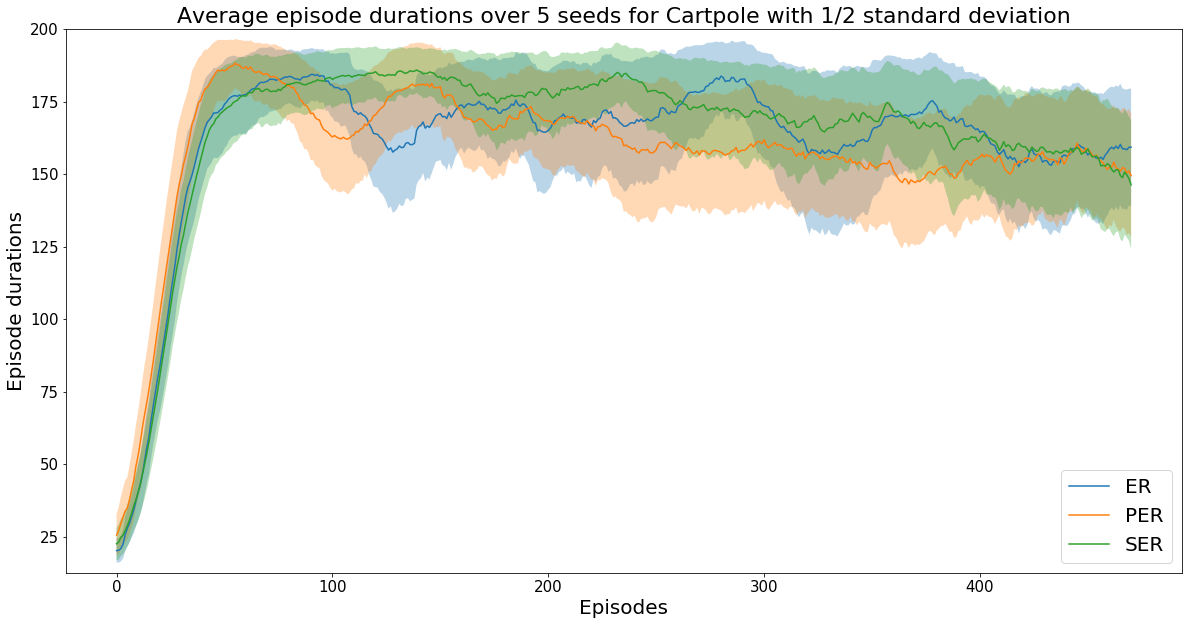

In [143]:
cartpole_500_steps = [d[:500] for d in cartpole_123]
#plot_results(cartpole_123,seed = 5,smooth_value=30,env_name="Cartpole")
plot_results(cartpole_500_steps,seed = 5,smooth_value=30,env_name="Cartpole")
#plt.savefig("Cartpole_results")

In [21]:
car_124 = pickle_action( 1, "Results/MountainCar-v0_final_results_meth124.p",action="r")
car_12 = remove_4_from_124(car_124)

car_3 = pickle_action( 3, "Results/MountainCar-v0_final_results_meth3.p",action="r")
car_4 = pickle_action( 3, "Results/MountainCar-v0_final_results_all_seeds_hindsight_k_6.p",action="r")

car_1234 = combine_durations(car_12,car_3,car_4)

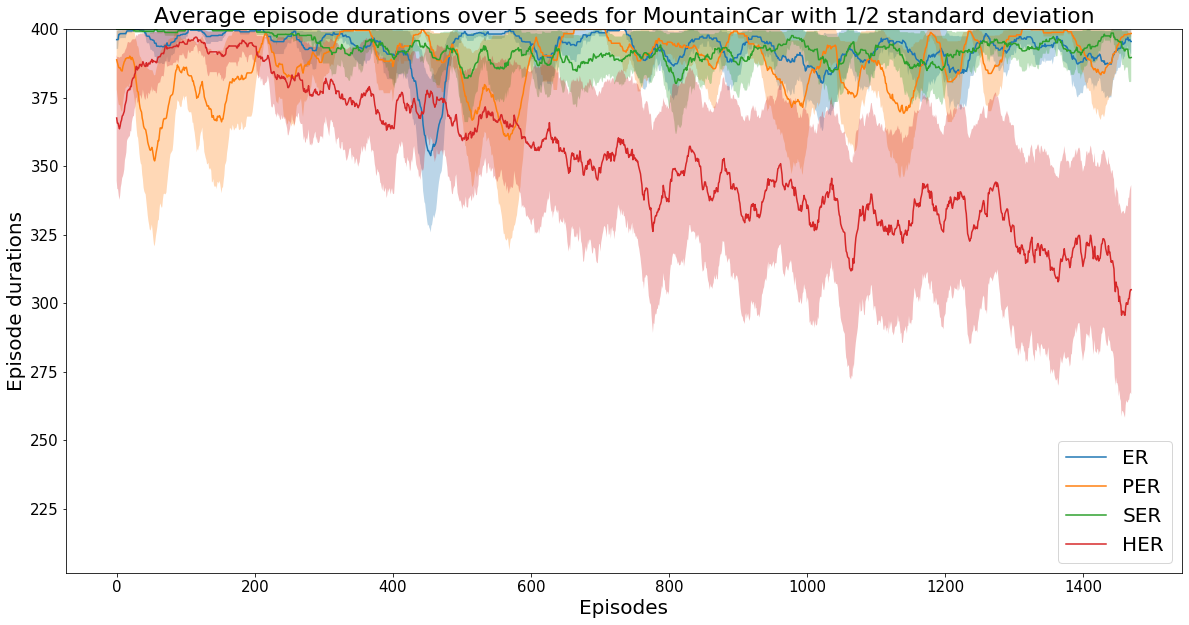

In [147]:
plot_results(car_1234,seed = 5,smooth_value=30,env_name="MountainCar")
#plt.savefig("MountainCar_results")

In [84]:
acrobot_12 = combine_seeds(acrobot_seed0_12,acrobot_seed3_12,acrobot_seed124_12,amount_methods=2)

In [89]:
acrobot_seed0_12 = pickle_action( 1, "Results/Acrobot-v1_intermediate_results_seed0_uniform_prioritized.p",action="r")
acrobot_seed3_12 = pickle_action( 1, "Results/Acrobot-v1_intermediate_results_seed3_uniform_prioritized.p",action="r")

acrobot_seed124_124 = pickle_action( 1, "Results/Acrobot-v1_final_results_seed_1_2_4_uniform_prioritized_hindsight.p",action="r")
acrobot_seed124_12 = remove_4_from_124(acrobot_seed124_124,n_seeds=3)

acrobot_12 = combine_seeds(acrobot_seed0_12,acrobot_seed3_12,acrobot_seed124_12,amount_methods=2)

acrobot_3 = pickle_action( 1, "Results/Acrobot-v1_final_results_all_seeds_selective.p",action="r")
acrobot_4 = pickle_action( 1, "Results/Acrobot-v1_final_results_all_seeds_hindsight_k_6.p",action="r")

acrobot_1234 = combine_durations(acrobot_12,acrobot_3,acrobot_4)
#combine_durations(list_1,list_2,list_3=[],methods_list_1 =2,n_seeds=5):

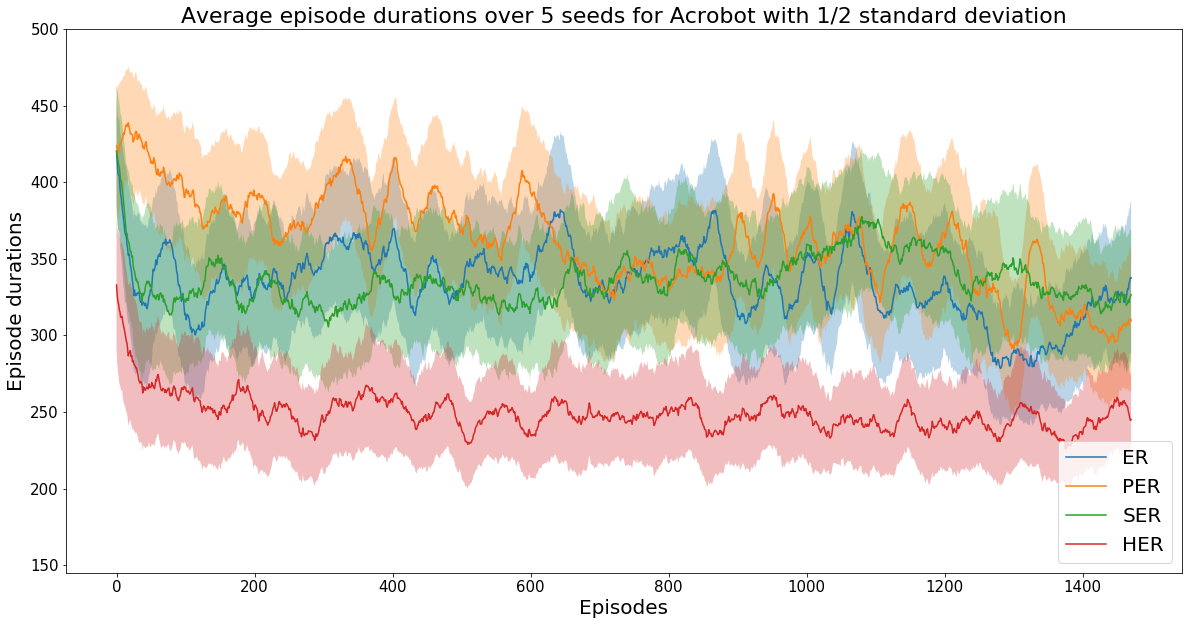

In [148]:
plot_results(acrobot_1234,seed = 5,smooth_value=30,env_name = "Acrobot")
#plt.savefig("Acrobot_results")

In [ ]:
end of experiments

## Messy/random codes after use
### Test runs

#### Set multiple seeds 

In [166]:
# We will seed the algorithm (before initializing QNetwork!) for reproducability

if "cuda" in device:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42 
#seed = 21
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)
np.random.seed(seed) #Added this seed for numpy, as used in selection action

#### Run it once 

In [165]:
#env = env_cartpole
#env = env_car
#env = env_pen
env = env_acrobot 

In [ ]:
#env._max_episode_steps = 400

In [177]:
#Hyperparameters
num_episodes = 1500
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for network, e.g. hidden dim
num_input = len(env.observation_space.sample())
num_hidden = 128
num_output = env.action_space.n

#Parameters for schedule of beta and alpha for prioritized replay
beta_max_iter = 1000
beta_start = 0.4
beta_end = 1.0
prioritized_replay_alpha = 0.6
#prioritized_replay_eps=1e-6 Set default in the training function

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
#Parameters for hindsight
k = 6
bigger_buffer_size = buffer_size * 2*k
env_name = env.unwrapped.spec.id

if env_name == "MountainCar-v0":
    env._max_episode_steps = 400

#Picking the memory type
memory_method = 4

if memory_method == 1:  #Uniform
    memory = ReplayMemory(buffer_size)
    train_func = train #Uniform
    select_action_func = select_action #epsilon greedy
    
elif memory_method == 2:   #Prioritzed
    memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
    train_func = train_prioritized #Prioritized Replay
    select_action_func = select_action #epsilon greedy

elif memory_method == 3:   #Selective
    memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
    train_func = train #same way as uniform
    select_action_func = select_action #epsilon greedy

elif memory_method == 4: #Hindsight
    num_input = 2 * num_input
    memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
    train_func = train #same way as uniform
    select_action_func = select_action #epsilon greedy

#Initialize model
model = QNetwork(device,num_input,num_hidden,num_output)
model = model.to(device)

#Running
start_time = time.time()
episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                beta_max_iter,beta_start,beta_end)
end_time = time.time()

print("Total duration time: ", str(end_time - start_time))

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [13:07<00:00,  1.90it/s]


Total duration time:  787.7378058433533


In [178]:
'''
obs = env.reset()
env.render()
done = False
count = 0
while not done:
    combined_s = np.concatenate( (obs, memory.true_goal_example))
    a = select_action_func(model, combined_s, 0.05)
    obs, reward, done, _ = env.step(a)
    env.render()
    time.sleep(0.05)
    count += 1
print(count)
    #print(obs)
env.close()  # Close the environment or you will have a lot of render screens soon
'''

400


### Hyperparameter grid search

#### Prioritized

In [ ]:
#Fixed Hyperparameters
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for selective
episodic_buffer_size = buffer_size * 6

#Parameters for hindsight
k = 6
env_name = env.unwrapped.spec.id
bigger_buffer_size = 10000 * k

all_durations = []
all_info = []
memory_method = 2
beta_max_iter = env._max_episode_steps * 0.5 * num_episodes

counter = 0 
for env in [env_acrobot]: #[env_cartpole, env_car, env_acrobot]:
    env_name = env.unwrapped.spec.id
    #if env_name == "MountainCar-v0":
    #    num_episodes = 1500
    #else:
    #    num_episodes = 1000
    
    #Parameters for network, e.g. hidden dim
    num_input = len(env.observation_space.sample())
    num_hidden = 128
    num_output = env.action_space.n

    for seed in [7,25]:#,17,50,60]:
        random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed) 
    
        for beta_start in [0,0.2,0.4]:
            for beta_end in [0.6,0.8,1.0]:
                for prioritized_replay_alpha in [0.4,0.6,0.8]:

                    if memory_method == 1:  #Uniform
                        memory = ReplayMemory(buffer_size)
                        train_func = train #Uniform
                        select_action_func = select_action #epsilon greedy

                    elif memory_method == 2:   #Prioritzed
                        memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
                        train_func = train_prioritized #Prioritized Replay
                        select_action_func = select_action #epsilon greedy

                    elif memory_method == 3:   #Selective
                        memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
                        train_func = train #same way as uniform
                        select_action_func = select_action #epsilon greedy

                    elif memory_method == 4: #Hindsight
                        num_input = 2 * num_input
                        memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
                        train_func = train #same way as uniform
                        select_action_func = select_action #epsilon greedy

                    #Initialize model
                    model = QNetwork(device,num_input,num_hidden,num_output)
                    model = model.to(device)

                    #Running
                    #start_time = time.time()
                    #episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                    #                                beta_max_iter,beta_start,beta_end)
                    #end_time = time.time()

                    #print("Total duration time: ", str(end_time - start_time))
                    
                    #all_durations.append(episode_durations)

                    #all_info.append( (env_name,"num_episodes: " + str(num_episodes), "seed: " + str(seed), 
                    #                "beta_start: " + str(beta_start),"beta_end: " + str(beta_end),"beta max iter: " + str(beta_max_iter)) )
                    if counter == 21:
                        print(beta_start)
                        print(beta_end)
                        print(prioritized_replay_alpha)
                    counter += 1
                    
                    #fig = plt.figure(figsize=(10,3))
                    #plt.plot(smooth(episode_durations, 1))
                    #plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)
                    #plt.show()
                
#pickle_action( "PER_hyper_results.p",action="w",[all_durations,all_info])

#### Selective


In [ ]:
#Fixed Hyperparameters
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for schedule of beta and alpha for prioritized replay
beta_max_iter = 1000
beta_start = 0.4
beta_end = 1.0
prioritized_replay_alpha = 0.6
#prioritized_replay_eps=1e-6 Set default in the training function

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
k = 4
env_name = env.unwrapped.spec.id
bigger_buffer_size = 10000 * k

all_durations = []
all_info = []
memory_method = 3

for env in [env_acrobot]: #[env_cartpole, env_car, env_acrobot]:
    env_name = env.unwrapped.spec.id
    
    #Parameters for network, e.g. hidden dim
    num_input = len(env.observation_space.sample())
    num_hidden = 128
    num_output = env.action_space.n

    for seed in [7,25]:#,17,50,60]:
        random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed) 
        
        for episodic_buffer_size in [buffer_size + 5000, buffer_size * 2, buffer_size * 4, buffer_size * 6]:

            if memory_method == 1:  #Uniform
                memory = ReplayMemory(buffer_size)
                train_func = train #Uniform
                select_action_func = select_action #epsilon greedy

            elif memory_method == 2:   #Prioritzed
                memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
                train_func = train_prioritized #Prioritized Replay
                select_action_func = select_action #epsilon greedy

            elif memory_method == 3:   #Selective
                memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
                train_func = train #same way as uniform
                select_action_func = select_action #epsilon greedy

            elif memory_method == 4: #Hindsight
                num_input = 2 * num_input
                memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
                train_func = train #same way as uniform
                select_action_func = select_action #epsilon greedy

            #Initialize model
            model = QNetwork(device,num_input,num_hidden,num_output)
            model = model.to(device)

            #Running
            start_time = time.time()
            episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                                    beta_max_iter,beta_start,beta_end)
            end_time = time.time()

            print("Total duration time: ", str(end_time - start_time))
                    
            all_durations.append(episode_durations)

            all_info.append( (env_name,"num_episodes: " + str(num_episodes), "seed: " + str(seed),"normal buffer size: " + str(buffer_size), 
                            "episodic buffer size: " + str(episodic_buffer_size)) ) 

            #fig = plt.figure(figsize=(10,3))
            #plt.plot(smooth(episode_durations, 1))
            #plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)
            #plt.show()
                
pickle_action( "SER_hyper_results.p",action="w",[all_durations,all_info])

#### Hindsight

In [ ]:
#Fixed Hyperparameters
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
buffer_size = 10000

#Parameters for schedule of beta and alpha for prioritized replay
beta_max_iter = 1000
beta_start = 0.4
beta_end = 1.0
prioritized_replay_alpha = 0.6
#prioritized_replay_eps=1e-6 Set default in the training function

#Parameters for selective
episodic_buffer_size = 12000

#Parameters for hindsight
k = 4
bigger_buffer_size = 10000 * k
env_name = env.unwrapped.spec.id

all_durations = []
all_info = []
memory_method = 4

for env in [env_acrobot]: #[env_cartpole, env_car, env_acrobot]:
    env_name = env.unwrapped.spec.id
    
    #Parameters for network, e.g. hidden dim
    num_input = 2 * len(env.observation_space.sample())
    num_hidden = 128
    num_output = env.action_space.n
    
    for seed in [7,25]:#,17,50,60]:
        random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed) 
        
        for k in [2,4,6]:
            for bigger_buffer_size  in [int(buffer_size*(0.5*k)),buffer_size*k, buffer_size*2*k]:

                if memory_method == 1:  #Uniform
                    memory = ReplayMemory(buffer_size)
                    train_func = train #Uniform
                    select_action_func = select_action #epsilon greedy

                elif memory_method == 2:   #Prioritzed
                    memory = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
                    train_func = train_prioritized #Prioritized Replay
                    select_action_func = select_action #epsilon greedy

                elif memory_method == 3:   #Selective
                    memory = SelectiveReplayMemory(buffer_size,episodic_buffer_size)
                    train_func = train #same way as uniform
                    select_action_func = select_action #epsilon greedy

                elif memory_method == 4: #Hindsight
                    #num_input = 2 * num_input
                    memory = HindsightReplayMemory(bigger_buffer_size,k,env_name)
                    train_func = train #same way as uniform
                    select_action_func = select_action #epsilon greedy

                #Initialize model
                model = QNetwork(device,num_input,num_hidden,num_output)
                model = model.to(device)

                #Running
                start_time = time.time()
                episode_durations = run_episodes(train_func,select_action_func, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                                                        beta_max_iter,beta_start,beta_end)
                end_time = time.time()

                print("Total duration time: ", str(end_time - start_time))

                all_durations.append(episode_durations)

                all_info.append( (env_name,"num_episodes: " + str(num_episodes), "seed: " + str(seed),
                                  "normal buffer size: " + str(buffer_size),
                                "bigger buffer size: " + str(bigger_buffer_size), "k: " + str(k)) ) 

                #fig = plt.figure(figsize=(10,3))
                #plt.plot(smooth(episode_durations, 1))
                #plt.title('Episode durations per episode for ' + env_name + " with " + memory.name)
                #plt.show()
                
pickle_action( "HER_hyper_results.p",action="w",[all_durations,all_info])